# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to turn our chatbot into a simple [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/).

The chatbot previously *always* reflected on the conversation and saved memories. 

The central difference is that the agent will decide *when* to save memories. 

For this, we're going to introduce a [router](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) that allows the agent to save memories. 

We're going to make this a fully featured companion chatbot. To do that, we're going to have multiple different memory types. We're going to have one that is a "user profile", and another that remembers information about other important people in the user's life.

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [ ]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Adding a router

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple: a router that decides when to update a user's profile, or the profile of key person in their life.

This will reflect on the chat history and any prior memories to decide whether to update a profile.

The updating itself will be handled by `Trustcall`, as before!


In [6]:
from pydantic import BaseModel, Field
from typing import Literal

# Schema for binary decision to save memories
class SaveMemory(BaseModel):
    """Whether to save information about the user, or about people in the user's life.

    `user`: Call this if the conversation contains information that is worth updating the user's profile
    `others`: Call this if the conversation contains information about OTHERS (not the user)
    `both`: Call this if the converstion contains information about both the user AND others
    `none`: Call this if no new information
    
    """
    store_memories: Literal['user', 'others', 'both', 'none'] = Field(description="Decision to save memories based on the conversation with the user.", )

LangChain's chat model [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface's [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method can be used to produce a binary decision.

We'll bind the `SaveMemory` schema to the model, which will enforce that the model makes a binary decision about whether to save memories.

In [4]:
_set_env("OPENAI_API_KEY")

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind the schema to the model
model_with_structure = model.with_structured_output(SaveMemory)

# Current memory collection
info = "This user's name is Lance and he likes to bike."

# System message
system_msg = f"""You manage are deciding whether to update the memory collection for the user.
Here is the current memory collection (it may be empty): <memories>{info}</memories>
Here is the chat history. Assess whether the chat history contains any information that should be added to the memory collection."""

# Invoke with new information
store_memories_flag = model_with_structure.invoke([SystemMessage(content=system_msg)]+[HumanMessage(content="I like to eat croissants")])
store_memories_flag.store_memories

'user'

In [10]:
# Invoke with new information
store_memories_flag = model_with_structure.invoke([SystemMessage(content=system_msg)]+[HumanMessage(content="I like to eat croissants with my friend Ben who lives in SF")])
store_memories_flag.store_memories

'both'

In [11]:
# Invoke with new information
store_memories_flag = model_with_structure.invoke([SystemMessage(content=system_msg)]+[HumanMessage(content="Hi!")])
store_memories_flag.store_memories

'none'

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

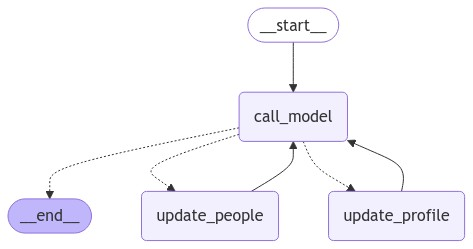

In [22]:
import uuid
from IPython.display import Image, display

from trustcall import create_extractor
from typing import TypedDict

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)


# Profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: str = Field(description="The user's name")
    job: str = Field(description="The user's job")
    age: str = Field(description="The user's age")
    interests: list[str] = Field(description="Interests that the user has")


class Person(Profile):
    """This is the profile of a person who is important to the user you are chatting with. This is NOT a profile for the user you are talking with"""
    relation: str = Field(description="relation to the user (friend, sibling, spouse, etc). The more specific the better!")    

# Create the Trustcall extractors
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)
person_extractor = create_extractor(
    model,
    tools=[Person],
    tool_choice="Person",
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time, as well as key people in their life.

User Profile:
<user_profile>
{user_profile}
</user_profile>

Key People:
<key_people>
{key_people}
</key_people>

If you want to update your memory of the user, please do so before responding by calling the `UpdateUser` tool.

If you want to update your memory of other key people, please do so before responding by calling the `UpdatePeople` tool."""

class UpdateUser(TypedDict):
    update_user: bool


class UpdatePeople(TypedDict):
    update_people: bool

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

# Node definitions
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve people memory from the store
    namespace = ("people", user_id)
    memories = store.search(namespace)
    key_people = "\n".join(f"{mem.value}" for mem in memories)
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, key_people=key_people)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdatePeople, UpdateUser], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}


def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_people(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("people", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "People"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"][:-1]))

    # Invoke the extractor
    result = person_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated people", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_people", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['name'] == "UpdatePeople":
            return "update_people"
        else:
            return "update_profile"

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_node(update_people)
builder.add_node(update_profile)
builder.add_conditional_edges("call_model", route_message)
builder.add_edge(START, "call_model")
builder.add_edge("update_people", "call_model")
builder.add_edge("update_profile", "call_model")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [23]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance.
================================== Ai Message ==================================
Tool Calls:
  UpdateUser (call_FEZIwrGF58J2ckH3d2KGRyKG)
 Call ID: call_FEZIwrGF58J2ckH3d2KGRyKG
  Args:
    update_user: True
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Hi Lance! It's great to meet you. How can I assist you today?


In [24]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================
Tool Calls:
  UpdateUser (call_p4PPZEtHK9BzVlERntMjLUan)
 Call ID: call_p4PPZEtHK9BzVlERntMjLUan
  Args:
    update_user: True
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Biking around San Francisco sounds like a lot of fun! Do you have any favorite routes or spots you like to visit while biking?


In [25]:
# User input 
input_messages = [HumanMessage(content="Yes, I went to the Marin headlands today. I went with Jenny my wife")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, I went to the Marin headlands today. I went with Jenny my wife
================================== Ai Message ==================================
Tool Calls:
  UpdatePeople (call_71kDR5z9x0SspXHY0f3SoU6A)
 Call ID: call_71kDR5z9x0SspXHY0f3SoU6A
  Args:
    update_people: True
================================= Tool Message =================================

updated people
================================== Ai Message ==================================

That sounds like a beautiful ride! The Marin Headlands offer some stunning views. How was the ride with Jenny? Did you both enjoy it?


We can continue chatting. 

In [26]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Good - she is just starting to bike")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Good - she is just starting to bike
================================== Ai Message ==================================
Tool Calls:
  UpdatePeople (call_jDaRAcZrdy5YtvdO4ZYsi2NP)
 Call ID: call_jDaRAcZrdy5YtvdO4ZYsi2NP
  Args:
    update_people: True
================================= Tool Message =================================

updated people
================================== Ai Message ==================================

That's great to hear! It's wonderful that Jenny is getting into biking. Do you have any tips or plans to help her as she starts out?


In [27]:
# Namespace for the memory to save
user_id = "1"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

{'name': 'Lance', 'job': '', 'age': '', 'interests': ['biking around San Francisco']}


In [28]:
# Namespace for the memory to save
user_id = "1"

# Search 
for memory in across_thread_memory.search(("people", user_id)):
    print(memory.value)

{'name': 'Jenny', 'job': 'beginner cyclist', 'age': '', 'interests': ['biking'], 'relation': 'wife'}


Now we can create a new thread and chat with the chatbot again.

It should retain the memories from the previous thread!

In [29]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="What bakeries would you recommend for me and my wife?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me and my wife?
================================== Ai Message ==================================

San Francisco has some fantastic bakeries that you and Jenny might enjoy, especially if you're planning a biking trip around the city. Here are a few recommendations:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit for anyone in San Francisco.

2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.

3. **Arizmendi Bakery** - A worker-owned cooperative bakery known for its fresh bread, pastries, and pizza.

4. **Craftsman and Wolves** - Offers innovative pastries and a unique twist on classic bakery items.

5. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative pastries.

These spots are perfect for a sweet treat or a quick snack during your biking adventures. 

Trace: 

https://smith.langchain.com/public/f267e203-d78a-4884-898f-8d5c84d5597c/r

## TODO: Show in Studio
